In [ ]:
!pip install mediapipe -q

In [9]:
# Import all necessary libraries.

import os
import cv2
import numpy as np
import pandas as pd
import mediapipe as mp
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Set a seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [10]:
# Load image file paths and their corresponding labels from the dataset directory.

DATASET_PATH = "/kaggle/input/yoga-pose-image-classification-dataset/dataset/"

filepaths = []
labels = []

# Walk through the dataset directory
for dirname, _, filenames in os.walk(DATASET_PATH):
    # The label is the name of the subfolder
    label = os.path.basename(dirname)
    for filename in filenames:
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            filepaths.append(os.path.join(dirname, filename))
            labels.append(label)

# Create a pandas DataFrame
df = pd.DataFrame({'filepath': filepaths, 'label': labels})

# Display basic information about the dataset
print(f"Total images found: {len(df)}")
print(f"Number of unique poses (classes): {df['label'].nunique()}")
print("\nDataset head:")
print(df.head())

Total images found: 5991
Number of unique poses (classes): 107

Dataset head:
                                            filepath             label
0  /kaggle/input/yoga-pose-image-classification-d...  virabhadrasana i
1  /kaggle/input/yoga-pose-image-classification-d...  virabhadrasana i
2  /kaggle/input/yoga-pose-image-classification-d...  virabhadrasana i
3  /kaggle/input/yoga-pose-image-classification-d...  virabhadrasana i
4  /kaggle/input/yoga-pose-image-classification-d...  virabhadrasana i


In [11]:
# Cell 3: Feature Extraction (MediaPipe Pose)

# Initialize MediaPipe Pose.
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, model_complexity=2, enable_segmentation=True)

def extract_and_normalize_landmarks(image_path):
    """
    Extracts and normalizes pose landmarks from a single image.
    Normalization involves centering the pose at the hip midpoint and scaling
    by the shoulder distance.
    """
    image = cv2.imread(image_path)
    if image is None:
        return None
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)
    
    if not results.pose_landmarks:
        return None

    landmarks = results.pose_landmarks.landmark
    
    # --- Normalization ---
    left_hip = landmarks[mp_pose.PoseLandmark.LEFT_HIP.value]
    right_hip = landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value]
    left_shoulder = landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value]
    right_shoulder = landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value]

    hip_midpoint = np.array([(left_hip.x + right_hip.x) / 2, 
                             (left_hip.y + right_hip.y) / 2,
                             (left_hip.z + right_hip.z) / 2])

    shoulder_dist = np.linalg.norm(np.array([left_shoulder.x, left_shoulder.y, left_shoulder.z]) - 
                                   np.array([right_shoulder.x, right_shoulder.y, right_shoulder.z]))
    
    if shoulder_dist < 1e-6:
        shoulder_dist = 1.0

    # 4. Extract, center, scale, and add visibility
    # The feature vector will be [x1, y1, z1, v1, x2, y2, z2, v2, ...]
    normalized_landmarks = []
    for lm in landmarks:
        normalized_landmarks.extend([
            (lm.x - hip_midpoint[0]) / shoulder_dist,
            (lm.y - hip_midpoint[1]) / shoulder_dist,
            (lm.z - hip_midpoint[2]) / shoulder_dist,
            lm.visibility  # Add visibility as the 4th feature for each landmark
        ])
        
    return normalized_landmarks

# Apply the feature extraction function to the DataFrame
print("\nStarting landmark extraction (with 132 features per image)...")
tqdm.pandas(desc="Extracting Landmarks")
df['landmarks'] = df['filepath'].progress_apply(extract_and_normalize_landmarks)

# Drop rows where landmarks could not be extracted
initial_count = len(df)
df.dropna(subset=['landmarks'], inplace=True)
final_count = len(df)
print(f"\nSuccessfully processed {final_count} out of {initial_count} images.")
print("Dropped images where MediaPipe could not detect a pose.")


Starting landmark extraction (with 132 features per image)...


Extracting Landmarks:   0%|          | 0/5991 [00:00<?, ?it/s]W0000 00:00:1762529422.101881    1646 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762529422.294190    1646 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Extracting Landmarks: 100%|██████████| 5991/5991 [08:45<00:00, 11.40it/s]


Successfully processed 5593 out of 5991 images.
Dropped images where MediaPipe could not detect a pose.


In [12]:
# Dataset Preparation

# Encode string labels into integers
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# Stratified splitting of the DataFrame
train_val_df, test_df = train_test_split(
    df,
    test_size=0.15,
    random_state=42,
    stratify=df['label_encoded']
)

train_df, val_df = train_test_split(
    train_val_df,
    test_size=(0.15 / 0.85),
    random_state=42,
    stratify=train_val_df['label_encoded']
)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

# Prepare features (X) and labels (y) from the split DataFrames
X_train = np.array(train_df['landmarks'].tolist())
y_train = np.array(train_df['label_encoded'].tolist())

X_val = np.array(val_df['landmarks'].tolist())
y_val = np.array(val_df['label_encoded'].tolist())

X_test = np.array(test_df['landmarks'].tolist())
y_test = np.array(test_df['label_encoded'].tolist())


# Custom PyTorch Dataset
class YogaPoseDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create Datasets
train_dataset = YogaPoseDataset(X_train, y_train)
val_dataset = YogaPoseDataset(X_val, y_val)
test_dataset = YogaPoseDataset(X_test, y_test)

# Create DataLoaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Display the head of the test_df to confirm it's populated
print("\nTest DataFrame head:")
print(test_df.head())

Training set size: 3915
Validation set size: 839
Test set size: 839

Test DataFrame head:
                                               filepath  \
1208  /kaggle/input/yoga-pose-image-classification-d...   
1056  /kaggle/input/yoga-pose-image-classification-d...   
1120  /kaggle/input/yoga-pose-image-classification-d...   
3316  /kaggle/input/yoga-pose-image-classification-d...   
707   /kaggle/input/yoga-pose-image-classification-d...   

                             label  \
1208               baddha konasana   
1056                    vriksasana   
1120  utthita hasta padangustasana   
3316             salamba sirsasana   
707                   bhujangasana   

                                              landmarks  label_encoded  
1208  [-0.11274748166639922, -1.8155593926819893, -1...             13  
1056  [0.15233108470603285, -0.9222637779539934, -3....            104  
1120  [0.3977087925608473, -1.7920778393129624, -1.9...             94  
3316  [0.1101347678918751, 0.27875

In [13]:
# Model Definition

class PoseMLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(PoseMLP, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(64, num_classes)
        )
        
    def forward(self, x):
        return self.layers(x)

# Model instantiation
INPUT_SIZE = X_train.shape[1]  # Should be 99 (33 landmarks * 3 coords)
NUM_CLASSES = len(label_encoder.classes_)

model = PoseMLP(input_size=INPUT_SIZE, num_classes=NUM_CLASSES).to(device)

# Print model summary
print(model)
print(f"\nInput feature size: {INPUT_SIZE}")
print(f"Number of output classes: {NUM_CLASSES}")

PoseMLP(
  (layers): Sequential(
    (0): Linear(in_features=132, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=64, out_features=107, bias=True)
  )
)

Input feature size: 132
Number of output classes: 107


In [14]:
# Training

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training parameters
NUM_EPOCHS = 60

# History trackers
train_loss_history = []
val_accuracy_history = []

print("Starting model training...")

for epoch in range(NUM_EPOCHS):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")
    for inputs, labels in train_pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_loss_history.append(epoch_loss)

    # --- Validation Phase ---
    model.eval()
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]")
        for inputs, labels in val_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
            
    epoch_accuracy = correct_predictions / total_samples
    val_accuracy_history.append(epoch_accuracy)
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Loss: {epoch_loss:.4f} - Val Accuracy: {epoch_accuracy:.4f}")

print("\nFinished Training.")

Starting model training...


Epoch 1/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 973.35it/s]


Epoch 1/60 - Loss: 4.4669 - Val Accuracy: 0.1669


Epoch 2/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1148.47it/s]


Epoch 2/60 - Loss: 3.8779 - Val Accuracy: 0.2455


Epoch 3/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1127.46it/s]


Epoch 3/60 - Loss: 3.3752 - Val Accuracy: 0.3361


Epoch 4/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1123.75it/s]


Epoch 4/60 - Loss: 2.9843 - Val Accuracy: 0.4029


Epoch 5/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1139.36it/s]


Epoch 5/60 - Loss: 2.6922 - Val Accuracy: 0.4565


Epoch 6/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1136.36it/s]


Epoch 6/60 - Loss: 2.5111 - Val Accuracy: 0.4899


Epoch 7/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1134.44it/s]


Epoch 7/60 - Loss: 2.3715 - Val Accuracy: 0.5280


Epoch 8/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1138.55it/s]


Epoch 8/60 - Loss: 2.2322 - Val Accuracy: 0.5626


Epoch 9/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1107.51it/s]


Epoch 9/60 - Loss: 2.1351 - Val Accuracy: 0.5626


Epoch 10/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1110.20it/s]


Epoch 10/60 - Loss: 2.0435 - Val Accuracy: 0.5757


Epoch 11/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1132.47it/s]


Epoch 11/60 - Loss: 1.9770 - Val Accuracy: 0.6091


Epoch 12/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1092.55it/s]


Epoch 12/60 - Loss: 1.8861 - Val Accuracy: 0.5948


Epoch 13/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1113.09it/s]


Epoch 13/60 - Loss: 1.8521 - Val Accuracy: 0.6055


Epoch 14/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1159.86it/s]


Epoch 14/60 - Loss: 1.7992 - Val Accuracy: 0.6174


Epoch 15/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1098.19it/s]


Epoch 15/60 - Loss: 1.7629 - Val Accuracy: 0.6257


Epoch 16/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1114.87it/s]


Epoch 16/60 - Loss: 1.7369 - Val Accuracy: 0.6293


Epoch 17/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1146.17it/s]


Epoch 17/60 - Loss: 1.6682 - Val Accuracy: 0.6389


Epoch 18/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 774.74it/s]


Epoch 18/60 - Loss: 1.6087 - Val Accuracy: 0.6246


Epoch 19/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1113.48it/s]


Epoch 19/60 - Loss: 1.6194 - Val Accuracy: 0.6389


Epoch 20/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1089.09it/s]


Epoch 20/60 - Loss: 1.5803 - Val Accuracy: 0.6341


Epoch 21/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1101.13it/s]


Epoch 21/60 - Loss: 1.5749 - Val Accuracy: 0.6436


Epoch 22/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1124.63it/s]


Epoch 22/60 - Loss: 1.5444 - Val Accuracy: 0.6448


Epoch 23/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1113.62it/s]


Epoch 23/60 - Loss: 1.5211 - Val Accuracy: 0.6329


Epoch 24/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1101.26it/s]


Epoch 24/60 - Loss: 1.4860 - Val Accuracy: 0.6567


Epoch 25/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1136.34it/s]


Epoch 25/60 - Loss: 1.5274 - Val Accuracy: 0.6436


Epoch 26/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1089.39it/s]


Epoch 26/60 - Loss: 1.4852 - Val Accuracy: 0.6448


Epoch 27/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1145.44it/s]


Epoch 27/60 - Loss: 1.4274 - Val Accuracy: 0.6627


Epoch 28/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1131.04it/s]


Epoch 28/60 - Loss: 1.4585 - Val Accuracy: 0.6460


Epoch 29/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1113.59it/s]


Epoch 29/60 - Loss: 1.4486 - Val Accuracy: 0.6555


Epoch 30/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1127.84it/s]


Epoch 30/60 - Loss: 1.4426 - Val Accuracy: 0.6627


Epoch 31/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1126.94it/s]


Epoch 31/60 - Loss: 1.4231 - Val Accuracy: 0.6722


Epoch 32/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1145.93it/s]


Epoch 32/60 - Loss: 1.3884 - Val Accuracy: 0.6734


Epoch 33/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1135.33it/s]


Epoch 33/60 - Loss: 1.4002 - Val Accuracy: 0.6615


Epoch 34/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1130.75it/s]


Epoch 34/60 - Loss: 1.3308 - Val Accuracy: 0.6806


Epoch 35/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1105.69it/s]


Epoch 35/60 - Loss: 1.3996 - Val Accuracy: 0.6675


Epoch 36/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1134.11it/s]


Epoch 36/60 - Loss: 1.3348 - Val Accuracy: 0.6758


Epoch 37/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1130.69it/s]


Epoch 37/60 - Loss: 1.3222 - Val Accuracy: 0.6698


Epoch 38/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1142.75it/s]


Epoch 38/60 - Loss: 1.3032 - Val Accuracy: 0.6889


Epoch 39/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1131.46it/s]


Epoch 39/60 - Loss: 1.3254 - Val Accuracy: 0.6841


Epoch 40/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1127.76it/s]


Epoch 40/60 - Loss: 1.3232 - Val Accuracy: 0.6853


Epoch 41/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1138.29it/s]


Epoch 41/60 - Loss: 1.3168 - Val Accuracy: 0.6877


Epoch 42/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1125.27it/s]


Epoch 42/60 - Loss: 1.2516 - Val Accuracy: 0.6937


Epoch 43/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1117.88it/s]


Epoch 43/60 - Loss: 1.2810 - Val Accuracy: 0.6865


Epoch 44/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1102.79it/s]


Epoch 44/60 - Loss: 1.2955 - Val Accuracy: 0.6925


Epoch 45/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1121.66it/s]


Epoch 45/60 - Loss: 1.3119 - Val Accuracy: 0.6806


Epoch 46/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1155.49it/s]


Epoch 46/60 - Loss: 1.2566 - Val Accuracy: 0.6985


Epoch 47/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 802.60it/s]


Epoch 47/60 - Loss: 1.2589 - Val Accuracy: 0.6853


Epoch 48/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1140.08it/s]


Epoch 48/60 - Loss: 1.2815 - Val Accuracy: 0.6841


Epoch 49/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1112.20it/s]


Epoch 49/60 - Loss: 1.2363 - Val Accuracy: 0.6937


Epoch 50/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1086.27it/s]


Epoch 50/60 - Loss: 1.2145 - Val Accuracy: 0.6901


Epoch 51/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1103.64it/s]


Epoch 51/60 - Loss: 1.2161 - Val Accuracy: 0.6925


Epoch 52/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1128.51it/s]


Epoch 52/60 - Loss: 1.2212 - Val Accuracy: 0.6937


Epoch 53/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1132.73it/s]


Epoch 53/60 - Loss: 1.2195 - Val Accuracy: 0.6794


Epoch 54/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1129.18it/s]


Epoch 54/60 - Loss: 1.1908 - Val Accuracy: 0.6841


Epoch 55/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1147.81it/s]


Epoch 55/60 - Loss: 1.2075 - Val Accuracy: 0.6901


Epoch 56/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1104.46it/s]


Epoch 56/60 - Loss: 1.2358 - Val Accuracy: 0.7092


Epoch 57/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1108.80it/s]


Epoch 57/60 - Loss: 1.2395 - Val Accuracy: 0.6973


Epoch 58/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1129.29it/s]


Epoch 58/60 - Loss: 1.1625 - Val Accuracy: 0.6841


Epoch 59/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1132.92it/s]


Epoch 59/60 - Loss: 1.2047 - Val Accuracy: 0.6865


Epoch 60/60 [Val]: 100%|██████████| 27/27 [00:00<00:00, 1159.37it/s]

Epoch 60/60 - Loss: 1.1964 - Val Accuracy: 0.6961

Finished Training.


Evaluating on Test Set: 100%|██████████| 27/27 [00:00<00:00, 983.31it/s]



Final Test Accuracy: 0.7175

Classification Report:
                               precision    recall  f1-score   support

         adho mukha svanasana       0.82      0.90      0.86        10
        adho mukha vriksasana       0.62      0.62      0.62         8
              agnistambhasana       0.75      0.60      0.67         5
              ananda balasana       1.00      0.89      0.94         9
                   anantasana       1.00      1.00      1.00         6
                 anjaneyasana       0.38      0.33      0.35         9
              ardha bhekasana       0.62      0.83      0.71         6
            ardha chandrasana       1.00      1.00      1.00         7
         ardha matsyendrasana       0.71      0.77      0.74        13
      ardha pincha mayurasana       1.00      0.67      0.80         6
             ardha uttanasana       0.57      0.89      0.70         9
           ashtanga namaskara       1.00      0.80      0.89         5
                astavak

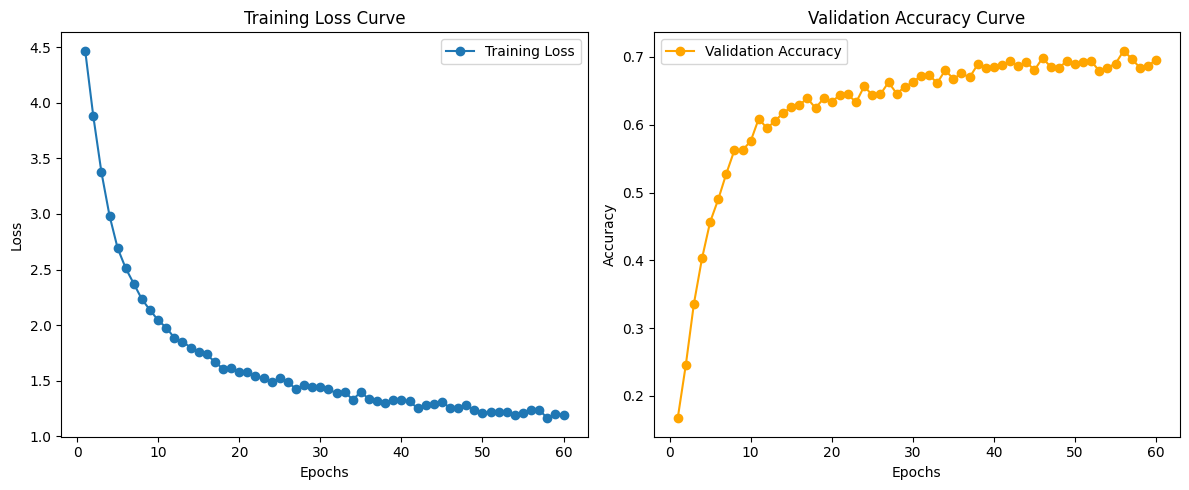

In [15]:
# Evaluation

y_pred_list = []
y_true_list = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Evaluating on Test Set"):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, y_pred = torch.max(outputs, 1)
        
        y_pred_list.extend(y_pred.cpu().numpy())
        y_true_list.extend(labels.cpu().numpy())

# Final Test Accuracy
test_accuracy = accuracy_score(y_true_list, y_pred_list)
print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")

# Classification Report
print("\nClassification Report:")
class_names = label_encoder.classes_
print(classification_report(y_true_list, y_pred_list, target_names=class_names, zero_division=0))

print("\nTop 10 Most Common Misclassifications")
conf_matrix = confusion_matrix(y_true_list, y_pred_list)
# Set diagonal to 0 to focus on errors
np.fill_diagonal(conf_matrix, 0)

# Find the top 10 errors
indices = np.argsort(conf_matrix, axis=None)[-10:]
top_errors = []
for idx in reversed(indices):
    true_class_idx, pred_class_idx = np.unravel_index(idx, conf_matrix.shape)
    error_count = conf_matrix[true_class_idx, pred_class_idx]
    if error_count > 0:
        true_class_name = class_names[true_class_idx]
        pred_class_name = class_names[pred_class_idx]
        top_errors.append((true_class_name, pred_class_name, error_count))

# Print the top errors
for true_name, pred_name, count in top_errors:
    print(f"'{true_name}' misclassified as '{pred_name}': {count} times")


# Plot Training Curves (Loss vs. Accuracy)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, NUM_EPOCHS + 1), train_loss_history, label='Training Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, NUM_EPOCHS + 1), val_accuracy_history, label='Validation Accuracy', marker='o', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Curve')
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
# Save & Load Model

MODEL_SAVE_PATH = "/kaggle/working/yoga_pose_mlp.pth"

# Save the model's state dictionary
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")

# Instantiate the model class again
loaded_model = PoseMLP(input_size=INPUT_SIZE, num_classes=NUM_CLASSES)

# Load the saved state dictionary
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Move the model to the appropriate device and set to evaluation mode
loaded_model.to(device)
loaded_model.eval()

print("\nModel loaded successfully and is ready for inference.")

Model saved to /kaggle/working/yoga_pose_mlp.pth

Model loaded successfully and is ready for inference.


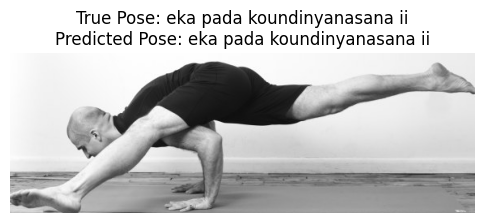

In [17]:
# Inference Example

def infer_pose(image_path, model, device, label_encoder_classes):
    """
    Performs inference on a single image.
    """
    # Extract and normalize landmarks
    landmarks = extract_and_normalize_landmarks(image_path)
    
    if landmarks is None:
        return "Could not detect a pose in the image."
    
    # Convert to PyTorch tensor
    features = torch.tensor(landmarks, dtype=torch.float32).unsqueeze(0).to(device)
    
    # Predict using the model
    model.eval()
    with torch.no_grad():
        outputs = model(features)
        _, predicted_idx = torch.max(outputs, 1)
    
    # Decode the prediction to the class name
    predicted_class_name = label_encoder_classes[predicted_idx.item()]
    
    return predicted_class_name

if not test_df.empty:
    random_sample = test_df.sample(3).iloc[0]
    image_path_to_test = random_sample['filepath']
    true_label = random_sample['label']

    # Run inference
    predicted_pose = infer_pose(image_path_to_test, loaded_model, device, label_encoder.classes_)

    # Display results
    image = cv2.imread(image_path_to_test)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(6, 6))
    plt.imshow(image_rgb)
    plt.title(f"True Pose: {true_label}\nPredicted Pose: {predicted_pose}")
    plt.axis('off')
    plt.show()
else:
    print("Inference DataFrame is empty. Cannot run inference example.")

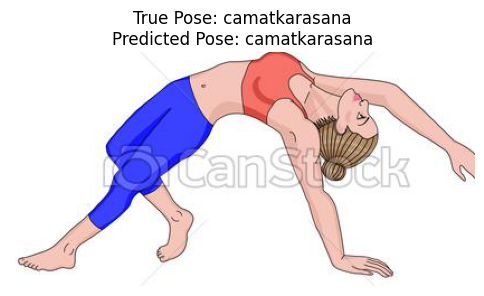

In [19]:
# Inference Example - 2

if not test_df.empty:
    random_sample = test_df.sample(7).iloc[0]
    image_path_to_test = random_sample['filepath']
    true_label = random_sample['label']

    # Run inference
    predicted_pose = infer_pose(image_path_to_test, loaded_model, device, label_encoder.classes_)

    # Display results
    image = cv2.imread(image_path_to_test)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(6, 6))
    plt.imshow(image_rgb)
    plt.title(f"True Pose: {true_label}\nPredicted Pose: {predicted_pose}")
    plt.axis('off')
    plt.show()
else:
    print("Inference DataFrame is empty. Cannot run inference example.")